Пример задачи оптимизации для производства

$$
f(x, b) = \max_y c^T x - c^T_b b - c^T_a y \\
\text{s.t.} ~~ Ax \leq b + y
$$

Подразумевается, что $x$ семплируется случайно, $b$ выбираем в начале, это интерпретируется как закупки в начале по оптовым ценам.

Также цены могут семплироваться случайно.

$y$ здесь закупки по ценам побольше.

Нужно при планируемом бюджете на начало периода принимать решение о распределении денег.

В качестве $b_i$ рассмотрим b, которые оказались достаточными для этого $x$

то есть $b_i = Ax_i$. 

Это нижняя оценка на траты в  этом периоде.

Проводится три исследования зависимости:
1. для разных бюджетов считаем получающиеся gamma и реальное отношение значений функций. 
2. сравниваем получающиеся отношения для точного решения и приближенного.
3. сравнение времен работ этих алгоритмов


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from tqdm import tqdm

# generator of data for experiment
from LS.linear_exp_generator import generate_cases

# function to compute gamma for proposed budget
from LS.exact_solver import gamma_exact

# function to compute exact gamma
from LS.altorithm import gamma_for_budget

from LS.utils.timer import timer
from LS.utils.exp_runner import compute_for_budgets
from LS.utils.drawer import plot_ratios

In [2]:
def get_ratios(b_s, cases, values):
    """
    computes exact solutions for founded b for different budgets
    """
    ratios = []
    for i in range(len(b_s)):
        b = b_s[i]
        new_values = np.array([f(b, True)[0] for f in cases])    
        ratio = values/new_values
        ratios.append(ratio)
    ratios = np.array(ratios)
    return ratios


In [7]:
num_cases = 50
num_resources = 600
num_products = 300
cases, values, budgets = generate_cases(m = num_cases, n = num_resources, k = num_products)

# inputs for algorithms
c_x = cases[0].cb
x_s = np.array(budgets)
v_s = np.array(values)
L_s = np.array(([ max((c.ca- c.cb).max(), c.cb.max()) for c in cases]))

# budgets to test
used_budgets = np.array([b @ c_x for b in budgets])
maxx = np.max(used_budgets)
max_budgets = np.linspace(maxx / 10, maxx* 1.5, 25)

In [8]:
rezults = []

y1 = r"$f_i(x)/v_i$"
x1 = r"Maximal budget, $B$"
l1 = r"$1 - \gamma \cdot C$"

# for L1 norm
# L_s = np.array(([ max((c.ca- c.cb).max(), c.cb.max()) for c in cases]))
# b_s, gammas, _ = compute_for_budgets(c_x, x_s, v_s, L_s, max_budgets, cases, norm=1, n_jobs= 10)
# ratios = get_ratios(b_s, cases, values)
# rez = {"name": "L1 approx", "ratios": ratios, "gammas": gammas, "x1": x1, "y1": y1,"l1": l1,}
# rezults.append(rez)

# for L2 norm
L_s =  np.array(([ np.linalg.norm(np.maximum(np.abs(c.ca- c.cb), c.cb)) for c in cases]))
b_s, gammas, _ = compute_for_budgets(c_x, x_s, v_s, L_s, max_budgets, cases, norm=2, n_jobs= 10)
ratios = get_ratios(b_s, cases, values)
rez = {"name": "L2 approx", "ratios": ratios, "gammas": gammas, "x1": x1, "y1": y1,"l1": l1,}
rezults.append(rez)


y1 = r"$f_i(x)/v_i$"
x1 = r"Maximal budget, $B$"
l1 = r"$1 - \gamma$"
# exact solution
b_s_ex, gammas_ex, _ = compute_for_budgets(c_x, x_s, v_s, L_s, max_budgets, cases, exact= True, n_jobs= 10)
ratios_ex = get_ratios(b_s_ex, cases, values)
rez = {"name": "Exact", "ratios": ratios_ex, "gammas": gammas_ex, "x1": x1, "y1": y1,"l1": l1,}
rezults.append(rez)

/Users/ilgam/miniconda3/envs/diploma/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/ilgam/miniconda3/envs/diploma/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/ilgam/miniconda3/envs/diploma/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/ilgam/miniconda3/envs/diploma/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more inform

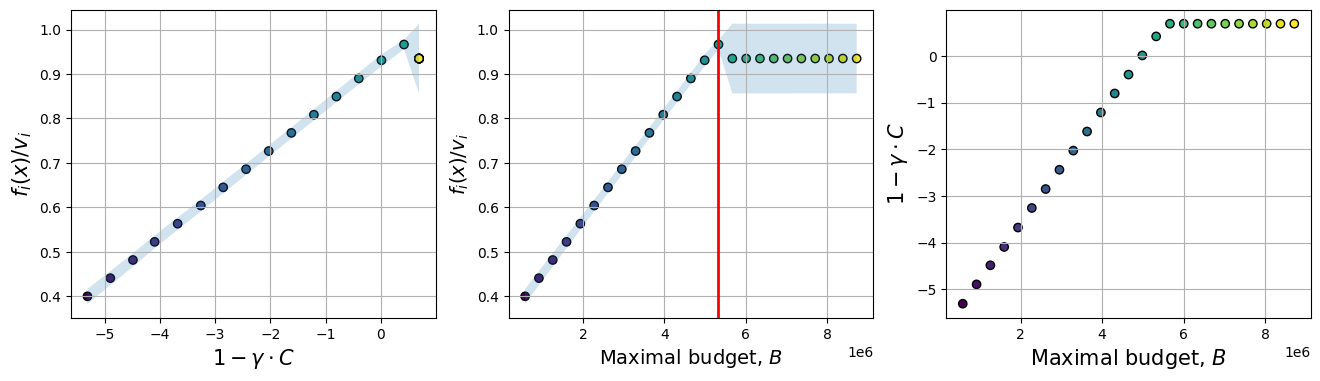

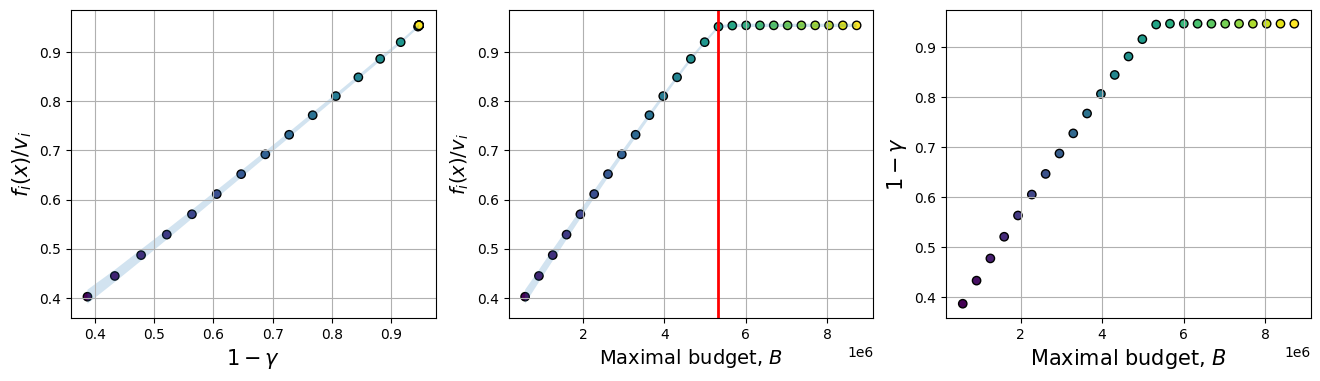

In [9]:
for r in rezults:
    fig = plot_ratios(**r, max_budgets= max_budgets, used_budgets=used_budgets)

[]

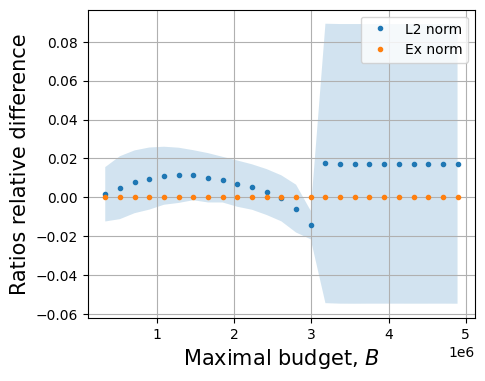

In [61]:
plt.figure(figsize = (5,4))
for r in rezults[:2]:
    ratios = 1/r['ratios']
    ratios_diff = (1/ratios_ex - ratios)/(1/ratios_ex)
    ratios__diff_stat = np.array([(np.mean(r), np.std(r)) for r in ratios_diff]).T
    colors =  np.linspace(0, 2., len(max_budgets))

    # plt.scatter(max_budgets, (ratios_diff).mean(1), c = colors, ec = 'k')
    plt.plot(max_budgets, ratios__diff_stat[0], '.', label = f"{r['name'][:2]} norm")
    plt.fill_between(max_budgets, ratios__diff_stat[0] - ratios__diff_stat[1], ratios__diff_stat[0] + ratios__diff_stat[1], alpha = 0.2)

plt.grid()
plt.legend()
plt.ylabel("Ratios relative difference", fontsize = 15)
plt.xlabel(x1, fontsize = 15)

plt.plot()

Посмотрим, насколько это решение хуже, чем решение задачи с использованием всех ограничений

In [73]:
b_s_ex, gammas_ex, times_ex = compute_for_budgets(c_x, x_s, v_s, L_s, max_budgets, cases, exact= True, n_jobs= 10)

ratios_ex = get_ratios(b_s_ex, cases, values)
ratios_stat = np.array([(np.mean(r), np.std(r)) for r in ratios_ex]).T
gm = 1/(1 - np.array(gammas_ex))

In [ ]:
y1 = r"$f^*/f(x)$"
x1 = r"Maximal budget, $B$"
l1 = r"$1/(1 - \gamma)$"

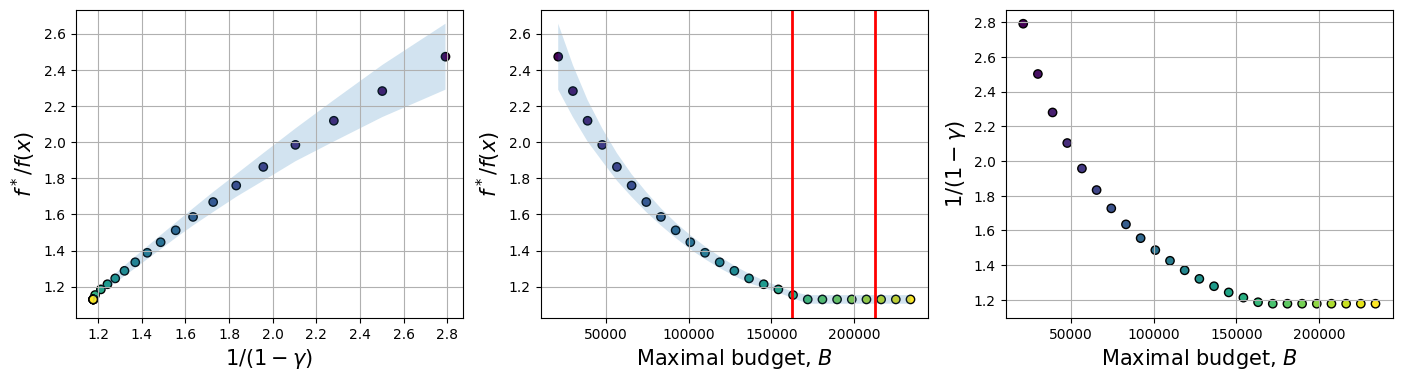

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (17, 4))
colors = np.linspace(0, 2., len(gm))
ax[0].scatter(gm , ratios_stat[0], c = colors, ec = 'k')
ax[0].fill_between(gm , ratios_stat[0] - ratios_stat[1], ratios_stat[0] + ratios_stat[1], alpha = 0.2)

ax[0].set_xlabel(l1, fontsize = 15)
ax[0].set_ylabel(y1, fontsize = 15)

ax[1].scatter(max_budgets, ratios_stat[0], c = colors, ec = 'k')
ax[1].fill_between(max_budgets, ratios_stat[0] - ratios_stat[1], ratios_stat[0] + ratios_stat[1], alpha = 0.2)
ax[1].axvline(used_budgets.min(),linewidth=2, color='r')
ax[1].axvline(used_budgets.max(),linewidth=2, color='r')

ax[1].set_xlabel(x1, fontsize = 15)
ax[1].set_ylabel(y1, fontsize = 15)
  
# ax[2].plot(max_costs, gammas)
ax[2].scatter(max_budgets, gm , c= colors, ec='k')

ax[2].set_xlabel(x1, fontsize = 15)
ax[2].set_ylabel(l1, fontsize = 15)
for i in range(3):
    ax[i].grid()

[]

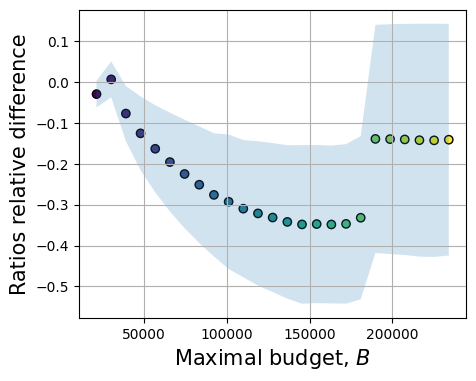

In [ ]:
ratios_diff = (ratios_ex - ratios)/ratios
ratios__diff_stat = np.array([(np.mean(r), np.std(r)) for r in ratios_diff]).T
colors =  np.linspace(0, 2., len(max_budgets))

plt.figure(figsize = (5,4))
plt.scatter(max_budgets, (ratios_diff).mean(1), c = colors, ec = 'k')
plt.fill_between(max_budgets, ratios__diff_stat[0] - ratios__diff_stat[1], ratios__diff_stat[0] + ratios__diff_stat[1], alpha = 0.2)

plt.grid()
plt.ylabel("Ratios relative difference", fontsize = 15)
plt.xlabel(x1, fontsize = 15)

plt.plot()

To test runtime just run function on different budget 5 times and plot the distributions

In [10]:
_, _, times = compute_for_budgets(c_x, x_s, v_s, L_s, max_budgets, cases,norm=2, exact= False, n_jobs= 10, iterations= 11)
_, _, times_ex = compute_for_budgets(c_x, x_s, v_s, L_s, max_budgets, cases, exact= True, n_jobs= 10, iterations= 11)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [04:42<00:00, 25.68s/it]


Text(0, 0.5, 'Time, $t$')

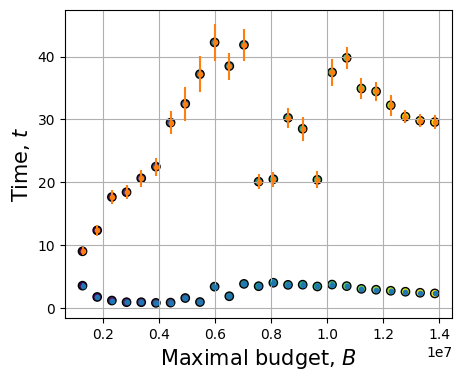

In [ ]:
t_stat = np.array([(np.mean(r), np.std(r)) for r in times.T]).T
t_stat_ex = np.array([(np.mean(r), np.std(r)) for r in times_ex.T]).T

plt.figure(figsize = (5,4))
for tt in [t_stat, t_stat_ex]:
    plt.errorbar(max_budgets, tt[0], tt[1], fmt = '.')
    plt.scatter(max_budgets, tt[0], c = colors, ec = 'k')
plt.grid()
plt.xlabel(x1, fontsize = 15)
plt.ylabel(r"Time, $t$", fontsize = 15)

Text(0, 0.5, 'Time, $t$')

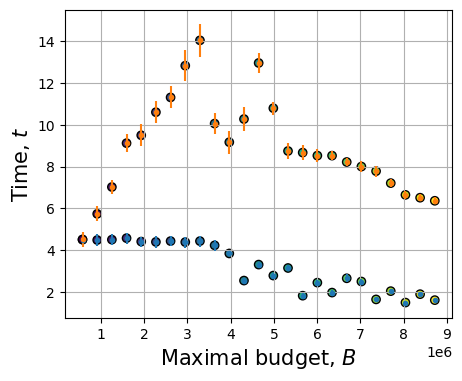

In [13]:
t_stat = np.array([(np.mean(r), np.std(r)) for r in times.T]).T
t_stat_ex = np.array([(np.mean(r), np.std(r)) for r in times_ex.T]).T
colors = np.linspace(0, 2., len(max_budgets))
plt.figure(figsize = (5,4))
for tt in [t_stat, t_stat_ex]:
    plt.errorbar(max_budgets, tt[0], tt[1], fmt = '.')
    plt.scatter(max_budgets, tt[0], c = colors, ec = 'k')
plt.grid()
plt.xlabel(x1, fontsize = 15)
plt.ylabel(r"Time, $t$", fontsize = 15)

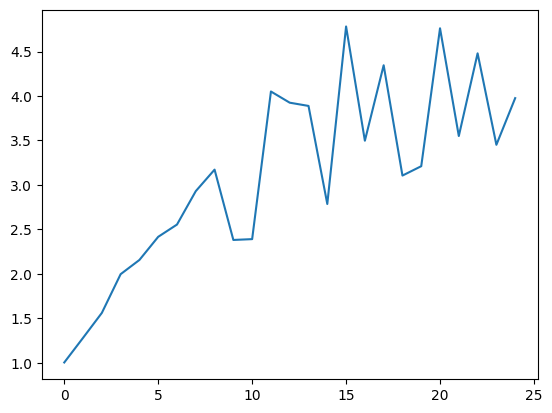

In [14]:
plt.plot(t_stat_ex[0]/t_stat[0])

In [ ]:
import json
times = {"approx": t_stat.tolist(), "exact": t_stat_ex.tolist()}
with open("runtimes.json", "w") as f:
    json.dump(times, f)